In [49]:
import os
import cv2
import numpy as np
import tqdm
from tqdm import tqdm_notebook


REBUILD_DATA = False

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []
    catcount = 0
    dogcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    pass
                   
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Cats: ", self.catcount)
        print("Dogs: ", self.dogcount)
        
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

In [9]:
training_data = np.load("training_data.npy", allow_pickle=True)

In [10]:
print(len(training_data))

24946


In [12]:
print(training_data[1])

[array([[ 82,  83,  84, ..., 113,  42,  40],
        [ 84,  84,  85, ..., 115,  46,  43],
        [ 85,  84,  85, ..., 117,  45,  45],
        ...,
        [ 56,  43,  43, ..., 123, 146, 121],
        [ 54,  40,  56, ...,  69,  78, 116],
        [ 52,  40,  54, ..., 115, 134,  54]], dtype=uint8) array([1., 0.])]


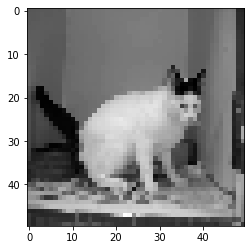

In [22]:
import matplotlib.pyplot as plt

plt.imshow(training_data[1][0], cmap="gray")
plt.show()

In [24]:
training_data[1][1]

array([1., 0.])

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        x = torch.randn(50, 50).view(-1, 1, 50, 50)
        self._to_linear = None
        self.convs(x)
        
        
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        
        print(x[0].shape)
        if self._to_linear is None:
            self._to_linear = np.prod(x[0].shape)
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
net = Net()

torch.Size([128, 2, 2])


In [29]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X) * VAL_PCT)
print(val_size)

2494


C:\Users\austi\AppData\Local\Temp/ipykernel_10692/3057618716.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)


In [31]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

22452
2494


In [34]:
BATCH_SIZE = 100
EPOCHS = 1

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i: i + BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i: i + BATCH_SIZE]

        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
print(loss)
        
        

  0%|          | 1/225 [00:00<00:36,  6.21it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  1%|▏         | 3/225 [00:00<00:31,  7.15it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  2%|▏         | 5/225 [00:00<00:29,  7.45it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 99%|█████████▉| 223/225 [00:29<00:00,  6.99it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


100%|██████████| 225/225 [00:29<00:00,  7.51it/s]

torch.Size([128, 2, 2])
tensor(0.2134, grad_fn=<MseLossBackward0>)


In [50]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm_notebook(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct += 1
        total += 1
        

C:\Users\austi\AppData\Local\Temp/ipykernel_10692/2213377905.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(test_X))):


  0%|          | 0/2494 [00:00<?, ?it/s]

Accuracy:  0.667


In [51]:
print("Accuracy: ", round(correct/ total, 3))

Accuracy:  0.667
